# 背景介绍

无论您是从精心策划的购物清单中选择购物，还是让奇思妙想随心选择物品，我们每一个人都有独特的购物爱好。

类似于天猫、京东和美团等电商和团购应用，Instacart是一款杂货店的订购和送货应用程序，该应用程序在让您可以在需要的时候轻松地将冰箱和储藏室装满您的个人喜好和主食。通过Instacart应用程序选择产品后，应用程序会检查您的订单，并为您安排人员进行店内购物和送货。

在上述的应用背景下，Instacart的数据科学团队的数据分析工作在提供这种愉快的购物体验方面起着重要作用。

目前，他们使用交易数据来开发模型，以预测用户将再次购买哪些产品，第一次尝试，或者在会话期间再次添加到购物车中。最近，Instacart公开发布了这些数据，内容涉及了超过3百万的Instacart订单信息。对于每个用户，提供了4到100个订单，并按每个订单购买的产品序列。同时，该数据还提供订单搁置的时长是一周或是一小时，以及两个订单之间的间隔时间。

希望大家能够使用这些数据来分析用户对产品的购买喜好，并尝试预测用户再次购买的产品的模型。

Instacart目前在生产类似数据时使用XGBoost，word2vec和Annoy来对用户以“再次购买”的产品意愿进行排序：并在用户购物时向用户推荐商品。

通过分析这些数据以及训练有效的预测算法使Instacart能够发现消费者购买杂货的意愿并更新自身的产品。

# 数据介绍

## 数据内容基本介绍

Instacart非常注意保护用户和零售合作伙伴的隐私，并确保数据完全匿名：

- 关于用户提供的唯一信息是他们的订单序列和订单中的产品
- 数据集中的所有ID都是完全随机化的，不能链接回任何其他ID
- 只有在多个零售商处由多人购买的产品才包含在内，且不提供零售商ID

请注意，此数据集包含来自许多不同零售商的订单，并且是Instacart生产数据的偏重子集，因此不一定是Instacart产品，用户或其购买行为的代表性样本。

本次实践提供的数据集是描述客户订单随时间变化的关系文件集。

该数据集是匿名的，包含来自超过200,000 Instacart用户的300多万份订单样本。

每个实体（客户，产品，订单，产品摆放位置等）都有一个关联的唯一ID。

各数据的基本内容了解:

   - `aisles`: 产品摆放的分类
   - `order_products__prior`: 订单产品关联表
   - `orders.csv`: 用户下单记录表。    
   - `products.csv`: 产品ID分类，及其摆放位置的关系表
   - `departments.csv`：  产品分类表

![关系图](./images/ERP.png)

## 加载数据

In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  

### order_products_train

In [2]:
order_products_train_df = pd.read_csv("./data/order_products_train.csv")
order_products_train_df.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### order_products_prior

In [3]:
order_products_prior_df = pd.read_csv("./data/order_products_prior.csv")
order_products_prior_df.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### orders

In [4]:
orders_df = pd.read_csv("./data/orders.csv")
orders_df.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### products

In [5]:
products_df = pd.read_csv("./data/products.csv")
products_df.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### aisles

In [6]:
aisles_df = pd.read_csv("./data/aisles.csv")
aisles_df.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### departments

In [7]:
departments_df = pd.read_csv("./data/departments.csv")
departments_df.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# 数据基本情况

## 数据缺失情况

In [8]:
order_products_all = pd.concat([order_products_train_df, order_products_prior_df], axis=0)

total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


## 数据集基本信息

### 先前订单集 训练集 预测集 订单量

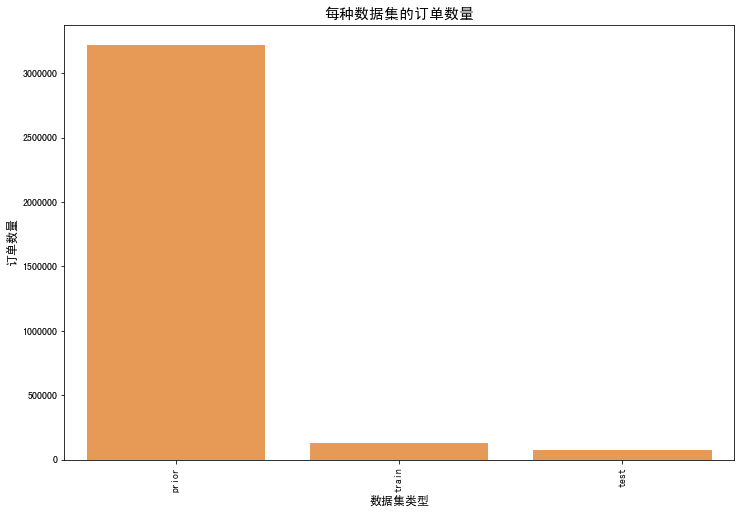

In [13]:
cnt_srs = orders_df.eval_set.value_counts()

# # 中文乱码的处理
plt.rcParams['font.sans-serif'] =['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('订单数量', fontsize=12)
plt.xlabel('数据集类型', fontsize=12)
plt.title('每种数据集的订单数量', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

###  有过订单的用户量

In [14]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

### 产品总量和下单过的产品量

In [15]:
len(np.unique(products_df['product_id'])), len(np.unique(products_df['product_name']))

(49688, 49688)

In [16]:
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("总共有 %s 订单， 涉及 %s 产品" %(orders_Unique, products_Unique))

总共有 3346083 订单， 涉及 49685 产品


# 数据分布分析

## 用户订单量分布

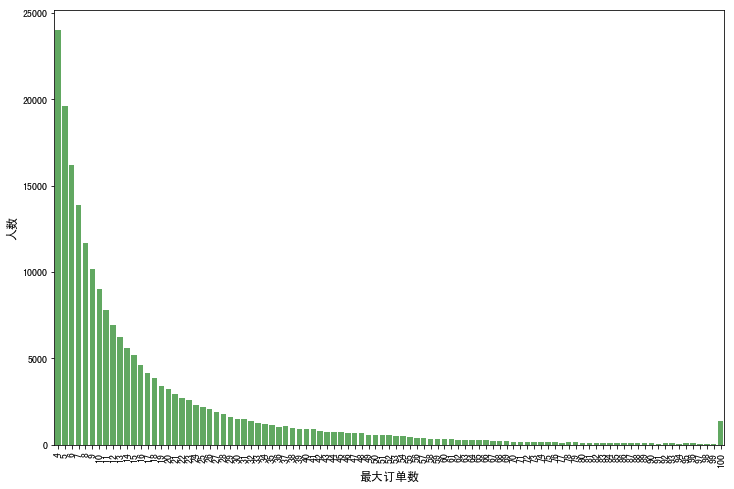

In [17]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('人数', fontsize=12)
plt.xlabel('最大订单数', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##  订单量--时间分析

### 一周内订单量

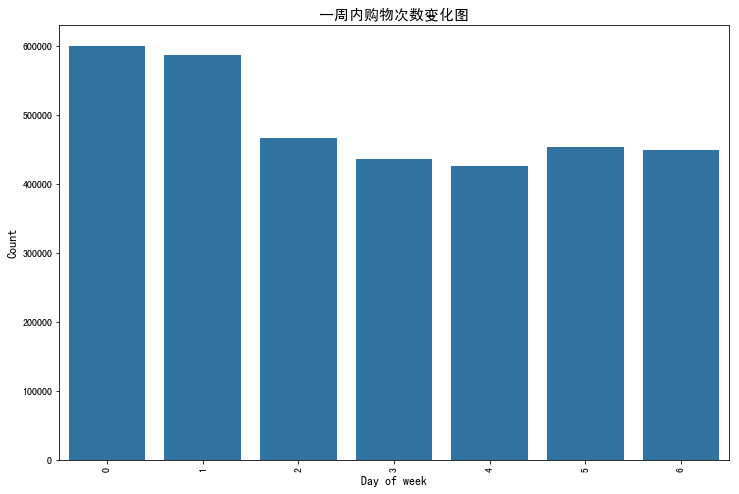

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("一周内购物次数变化图", fontsize=15)
plt.show()

### 一天内订单

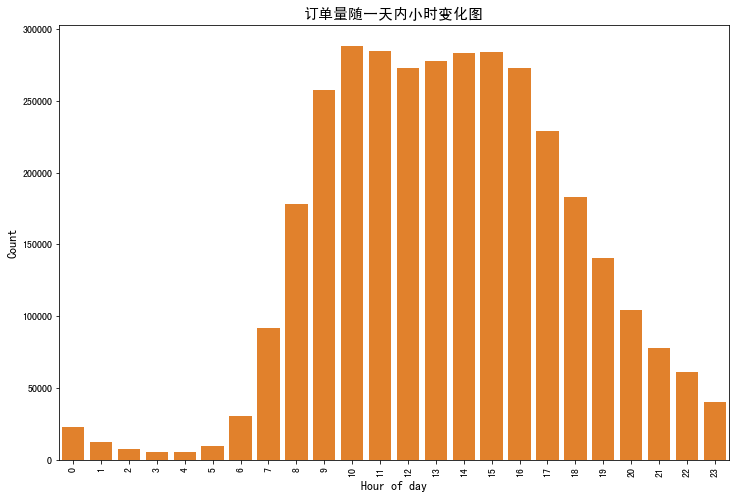

In [22]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("订单量随一天内小时变化图", fontsize=15)
plt.show()

###  订单量 --- 星期几和小时

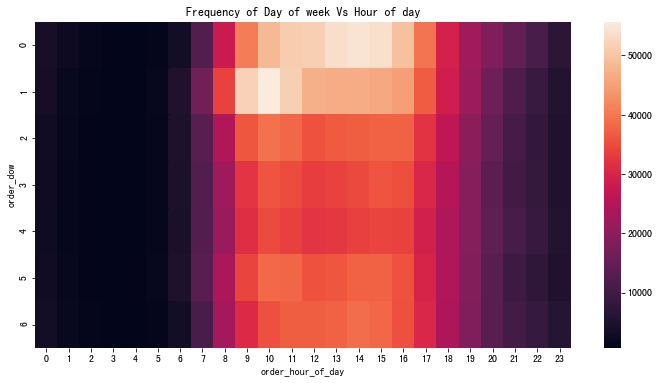

In [23]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

### 订单时间间隔

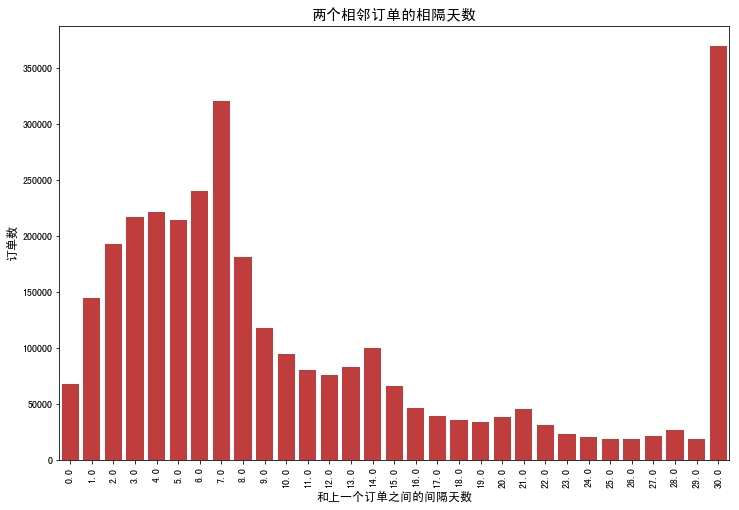

In [24]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('订单数', fontsize=12)
plt.xlabel('和上一个订单之间的间隔天数', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("两个相邻订单的相隔天数", fontsize=15)
plt.show()

## 订单--产品分析

### 订单中产品数量

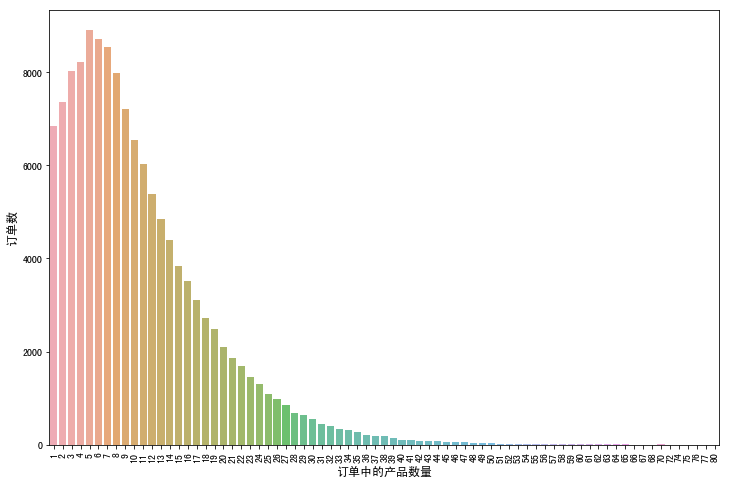

In [25]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('订单数', fontsize=12)
plt.xlabel('订单中的产品数量', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

###  产品--订单量分析

In [26]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [27]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


## 订单--产品分类分析

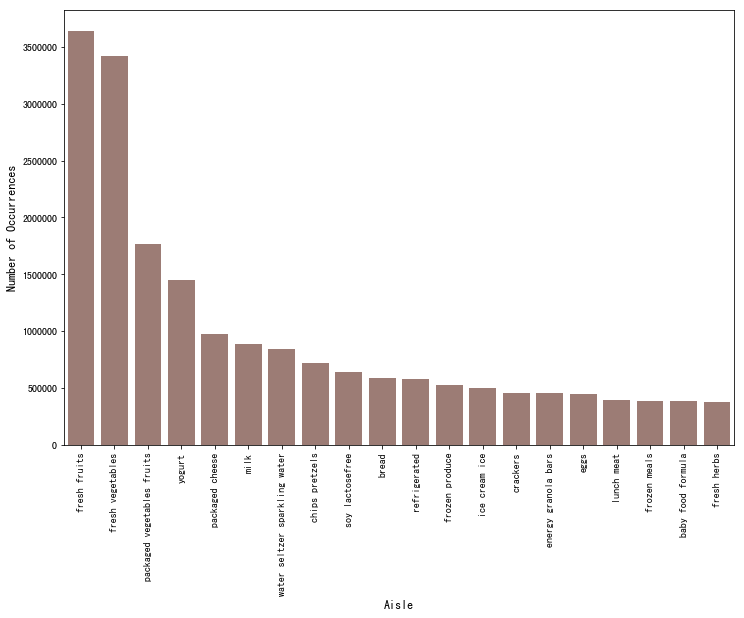

In [29]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## 订单--部门分析

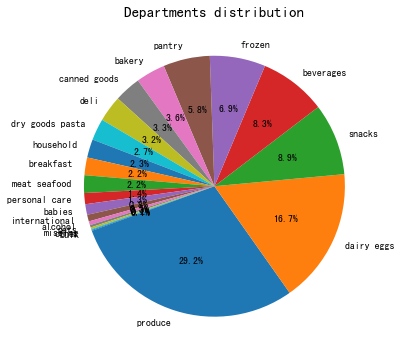

In [34]:
plt.figure(figsize=(6,6))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

## 影响再次下单的因素分析

### 再次下单--产品

In [35]:
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [36]:
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

In [37]:
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [38]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

###  产品类别--再次下单占比

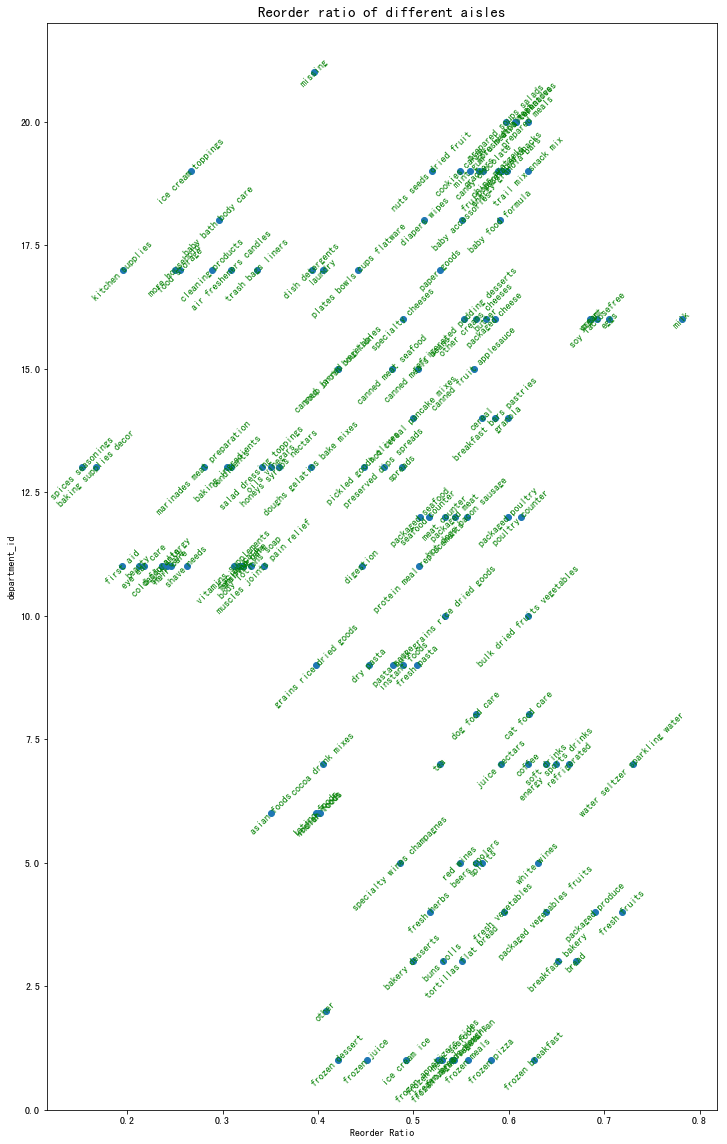

In [40]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

### 部门--产品再次下单比例

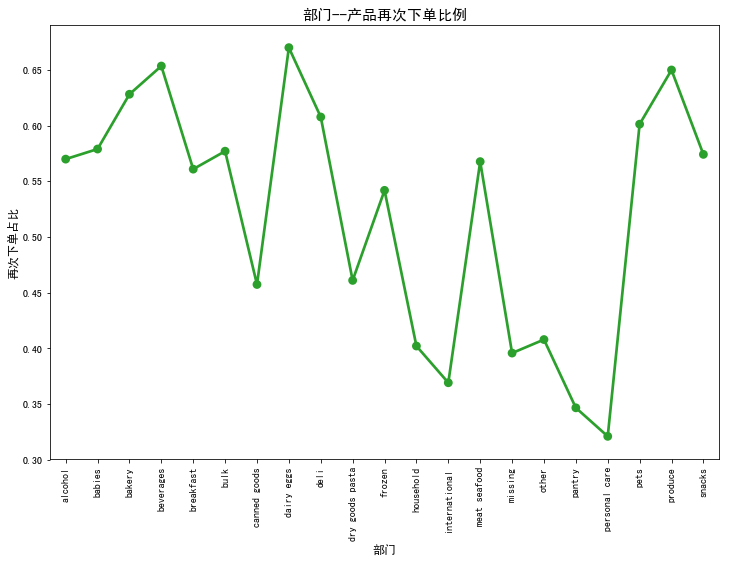

In [41]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('再次下单占比', fontsize=12)
plt.xlabel('部门', fontsize=12)
plt.title("部门--产品再次下单比例", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### 加入购物车--再次下单比例

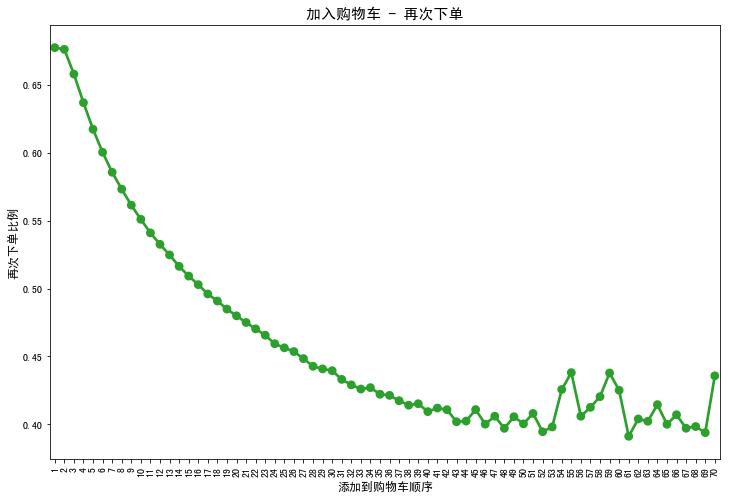

In [42]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('再次下单比例', fontsize=12)
plt.xlabel('添加到购物车顺序', fontsize=12)
plt.title("加入购物车 - 再次下单", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### 基于时间的变量--产品再次下单比率

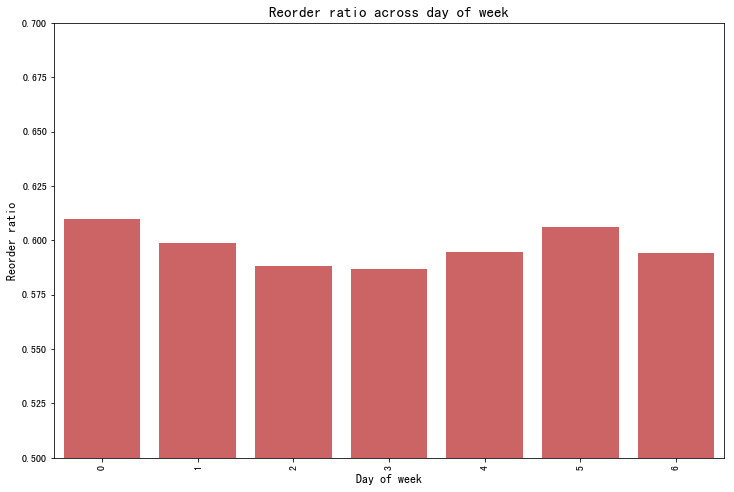

In [43]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

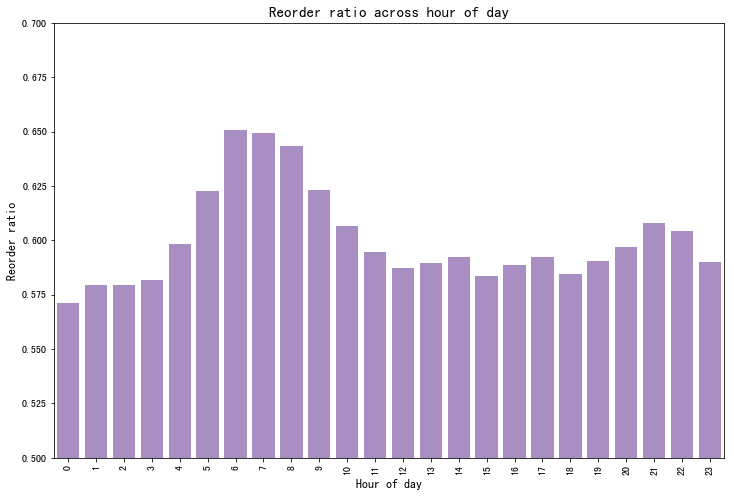

In [44]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

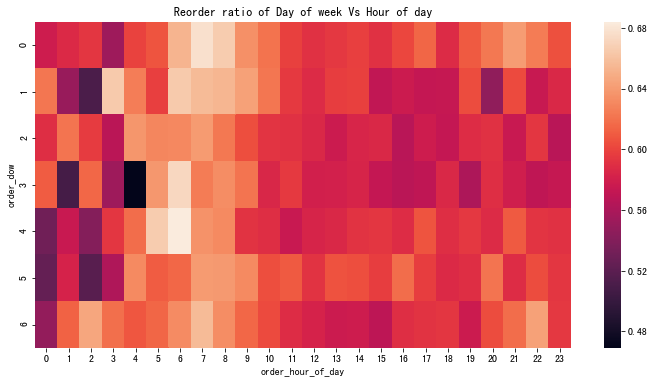

In [45]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

# 多因素分析

## 产品量--产品摆放类别--部门

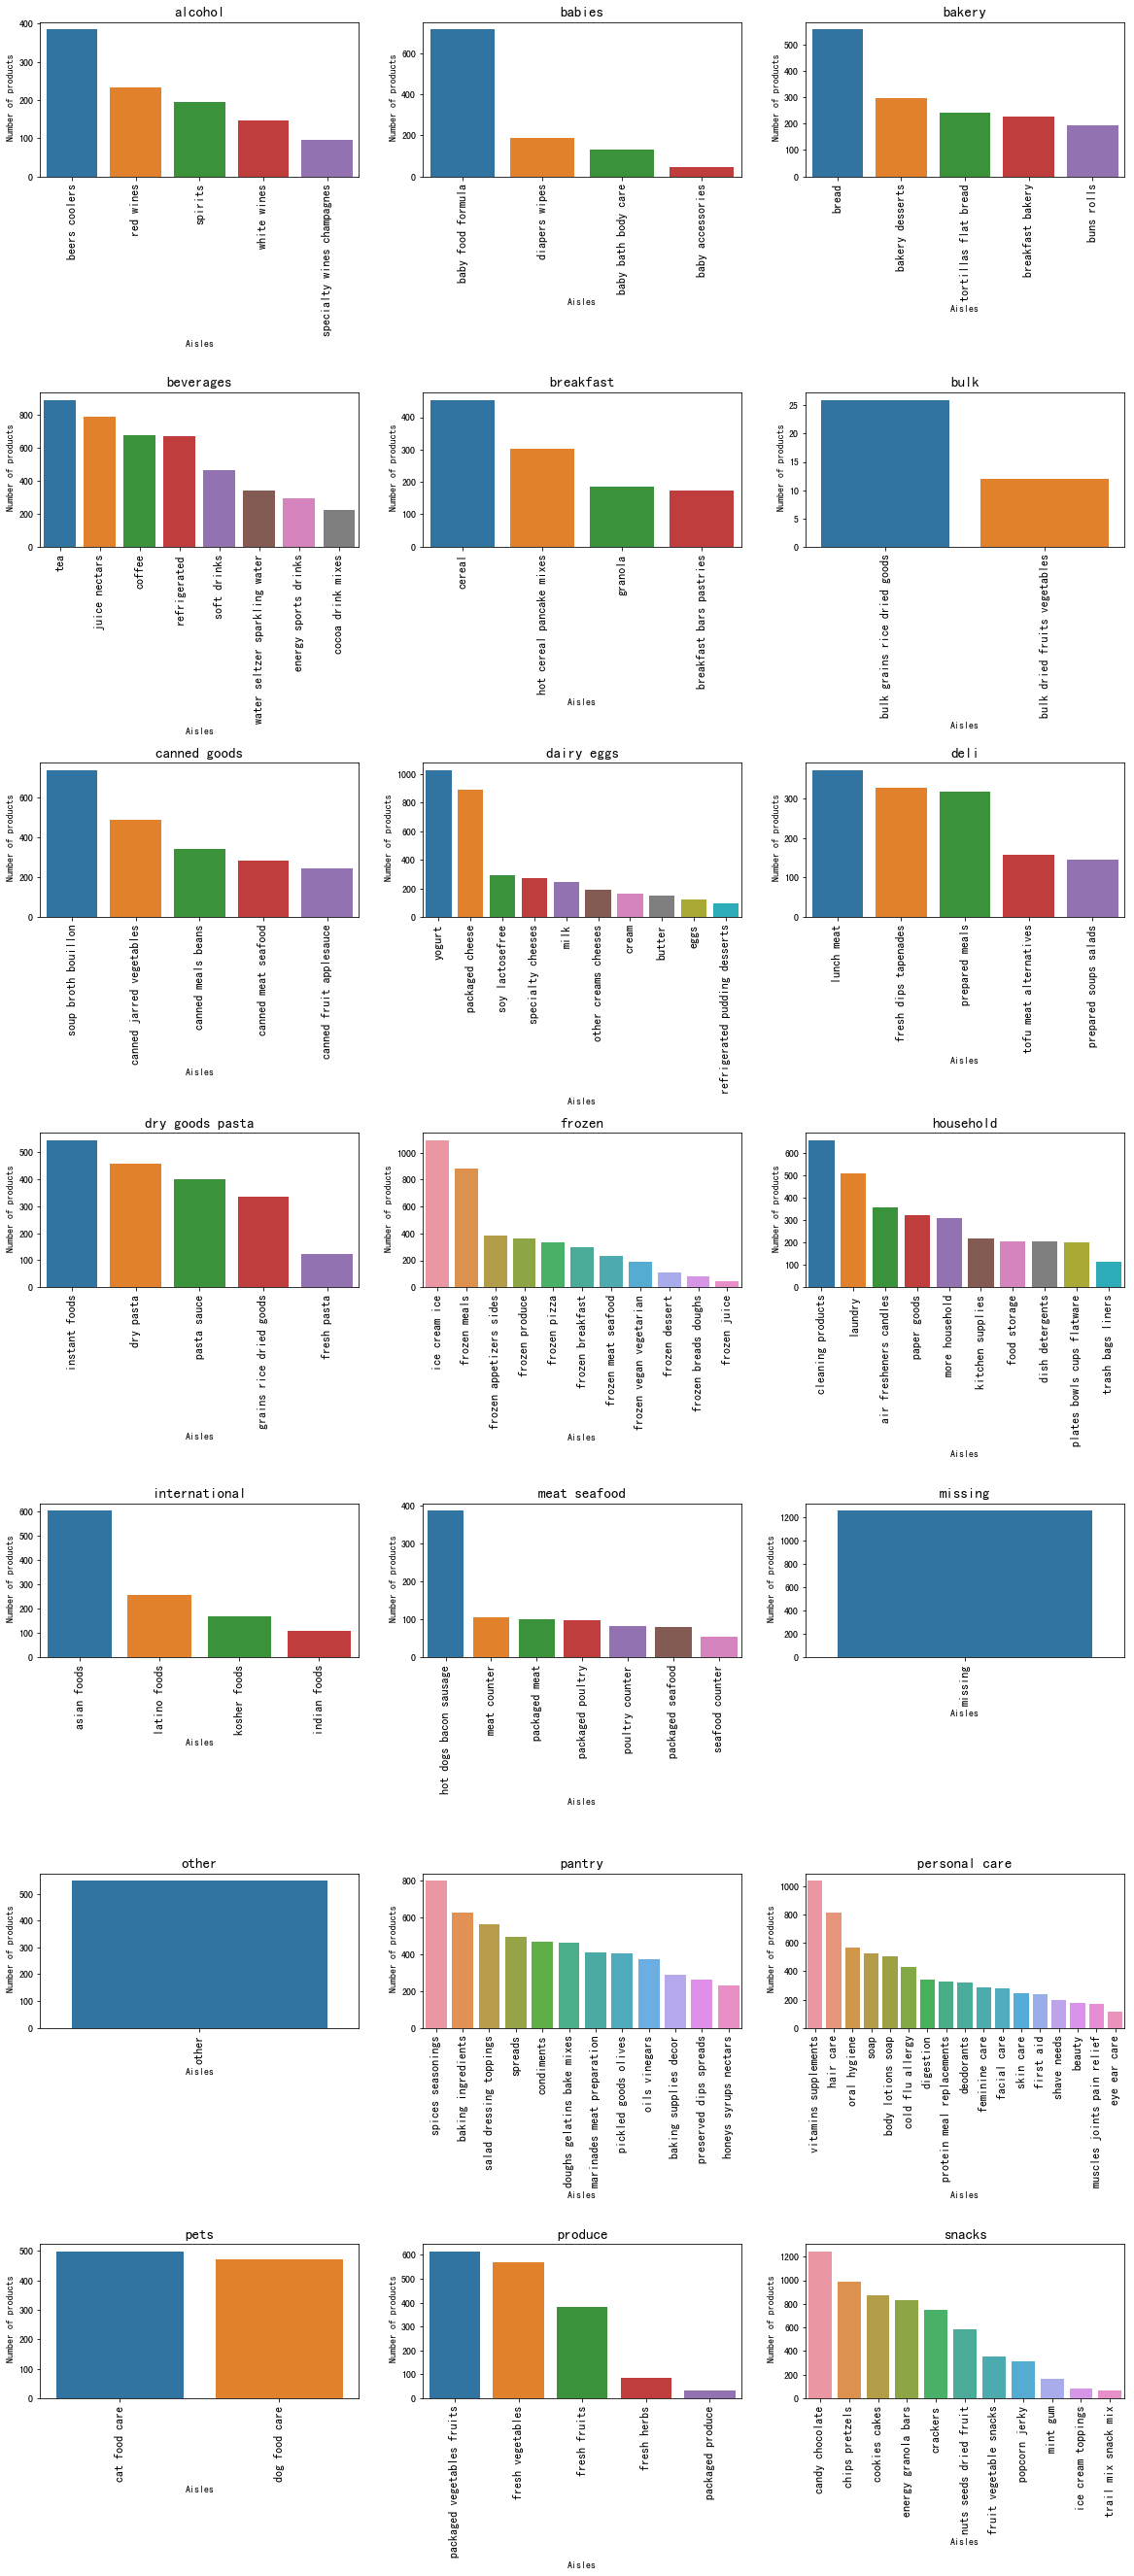

In [46]:
items  = pd.merge(left =pd.merge(left=products_df, right=departments_df, how='left'), right=aisles_df, how='left')


grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## 订单量--产品摆放类别--部门

In [48]:
users_flow = orders_df[['user_id', 'order_id']].merge(order_products_train_df[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped

,department,aisle,Total_orders
0,alcohol,beers coolers,1839
1,alcohol,red wines,1243
2,alcohol,specialty wines champagnes,461
3,alcohol,spirits,967
4,alcohol,white wines,1088
5,babies,baby accessories,306
6,babies,baby bath body care,328
7,babies,baby food formula,13198
8,babies,diapers wipes,1109
9,bakery,bakery desserts,1501


In [49]:
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

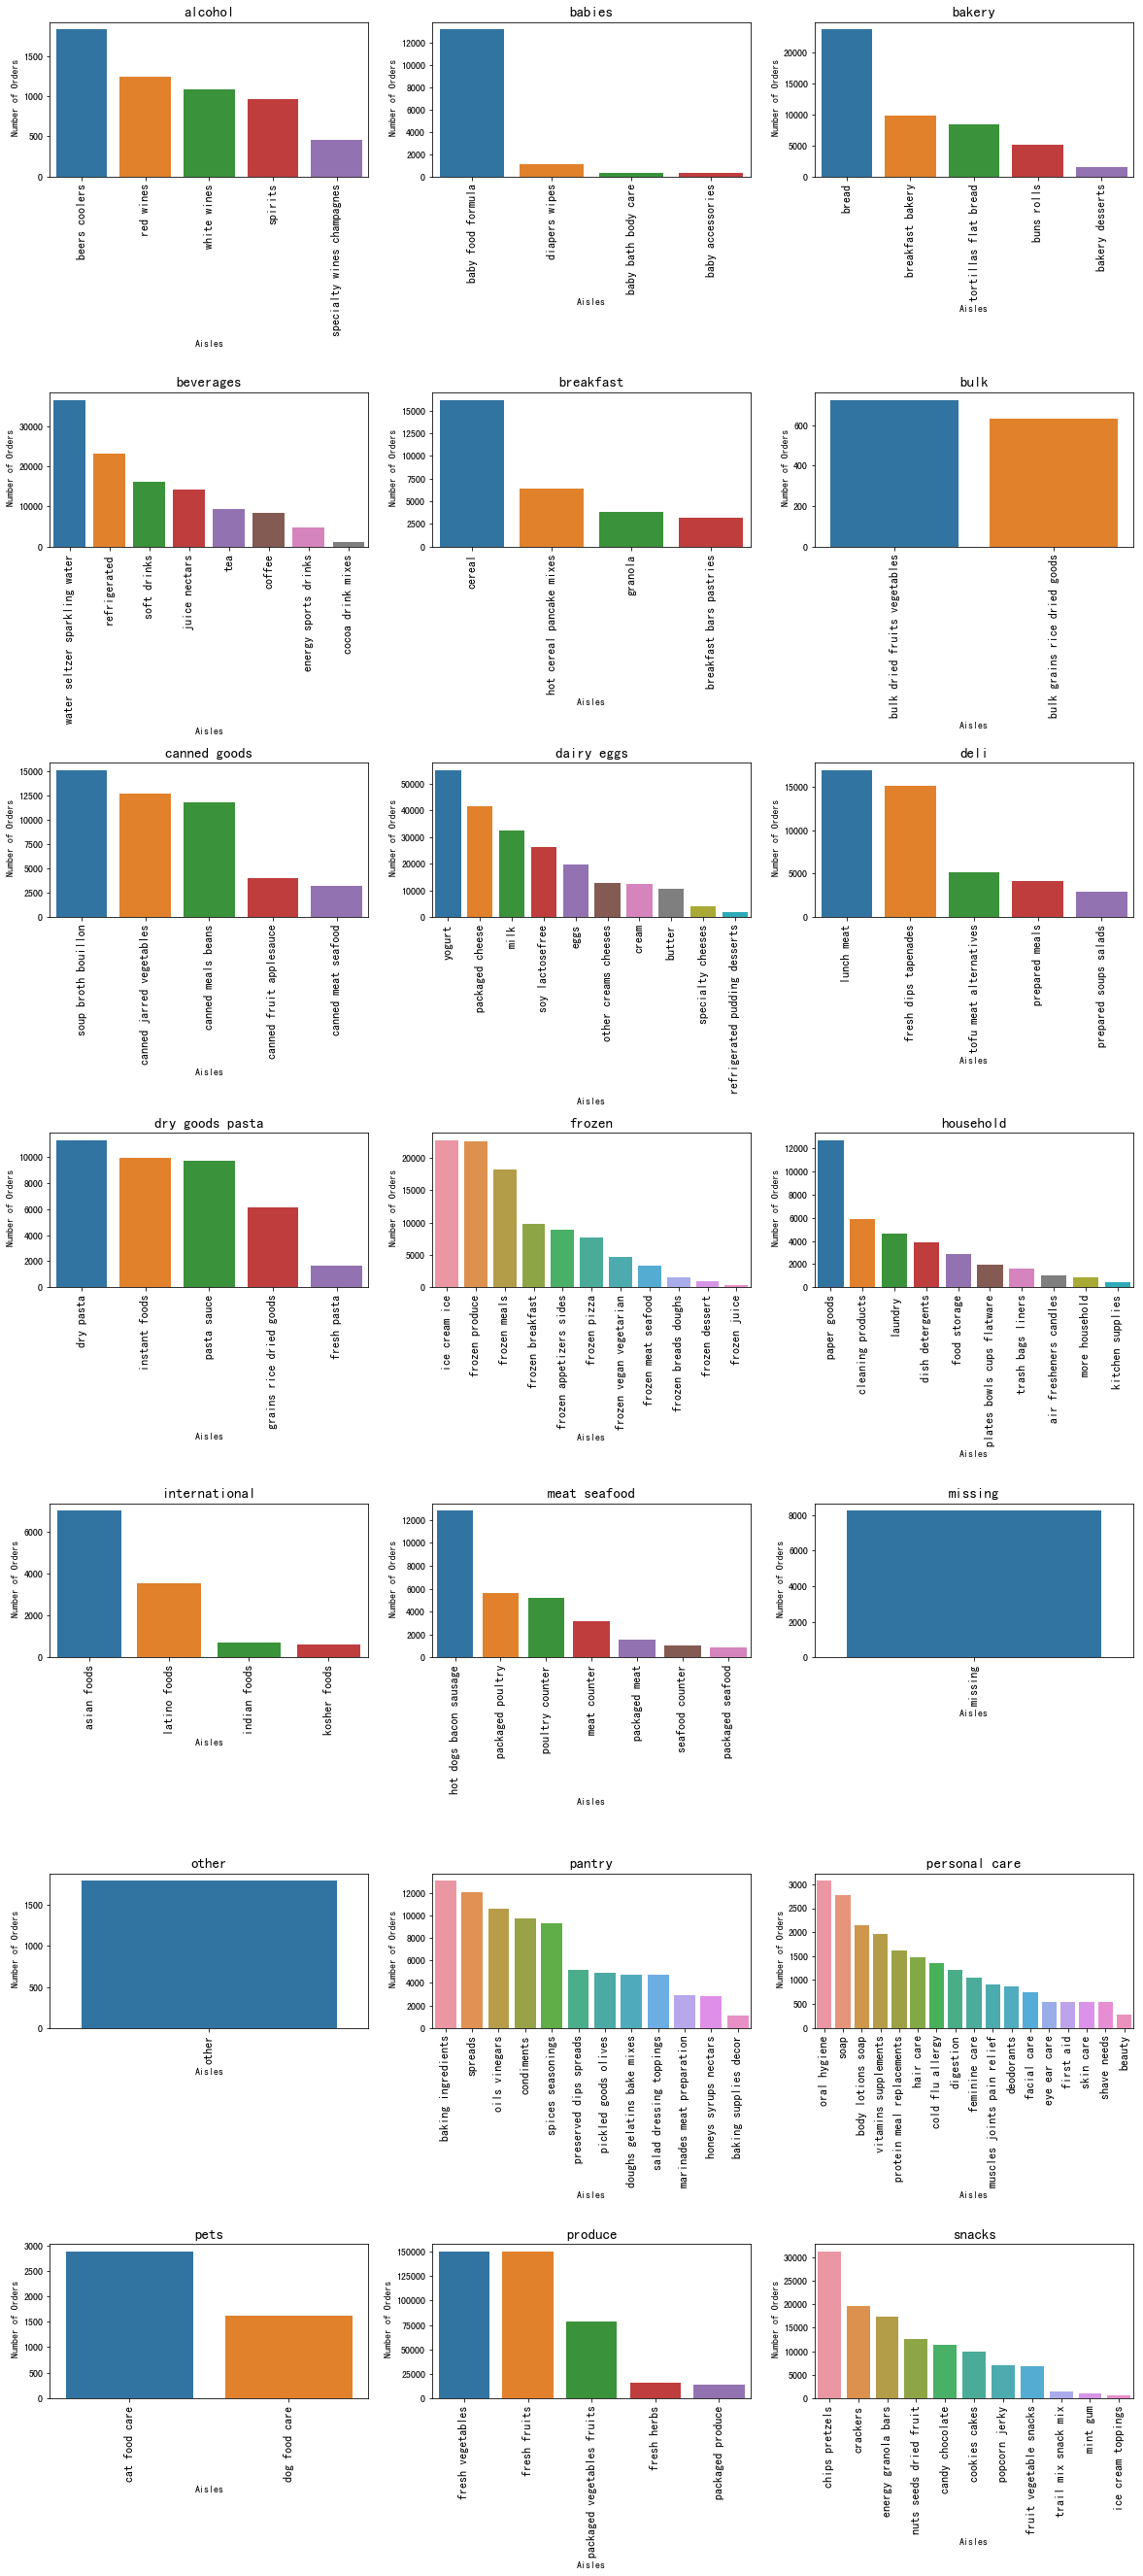

In [50]:
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

# 客户细分-主成分分析法

##  数据预处理

In [67]:
order_products_train_df = pd.read_csv("./data/order_products_train.csv")

In [68]:
order_products_prior_df = pd.read_csv("./data/order_products_prior.csv")

In [69]:
orders_df = pd.read_csv("./data/orders.csv")

In [70]:
products_df = pd.read_csv("./data/products.csv")

In [71]:
aisles_df = pd.read_csv("./data/aisles.csv")

In [72]:
departments_df = pd.read_csv("./data/departments.csv")

In [73]:
order_products_prior_df = order_products_prior_df[0:300000]

In [74]:
order_prior = pd.merge(order_products_prior_df,orders_df,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [75]:
products_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv('./data/aisles.csv')

_mt = pd.merge(order_products_prior_df,products_df, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders_df,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles_df,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [76]:
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [77]:
len(mt['product_name'].unique())

24836

## 用户分类

In [78]:
len(mt['aisle'].unique())

134

In [79]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

In [80]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
cust_prod.shape

(25831, 134)

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [83]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030292,-0.898990,-0.587639,-0.998578
1,-1.972748,-0.487659,-0.120542,0.213080,0.046021,-0.181881
2,-1.168974,1.284089,3.228124,0.594045,-0.648821,-1.091883
3,-1.433967,1.250081,3.261985,1.237747,-0.353550,-0.346490
4,-2.070709,-0.422148,-0.101552,0.278143,0.005870,-0.097195


(25831, 2)
          4         1
0 -0.587639  1.005868
1  0.046021 -0.487659
2 -0.648821  1.284089
3 -0.353550  1.250081
4  0.005870 -0.422148


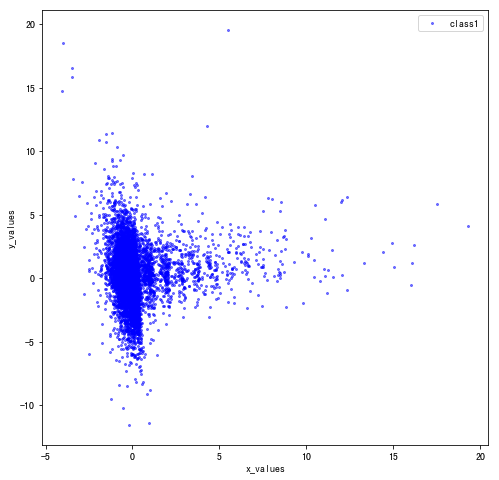

In [84]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.00793071 -2.39936986]
 [-0.04626512 -0.15452148]
 [-0.249524    2.06102734]
 [ 5.55591955  1.45663525]]


In [86]:
print (c_preds[0:100])

[2 1 2 2 1 1 1 1 1 1 0 1 2 1 1 3 1 1 2 1 1 1 1 1 1 2 0 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 2 2 0 1 1 1 1 1 2 2 1 1 0 2 1 1 1 1 1 2 1 1 2 1 1 1]


['purple', 'blue', 'purple', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


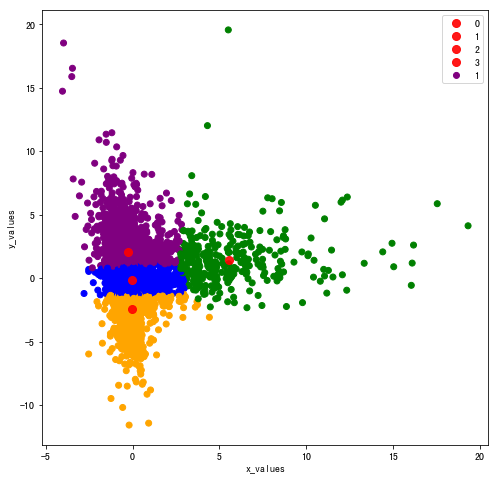

In [87]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [88]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,2
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,2
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


(25831, 135)


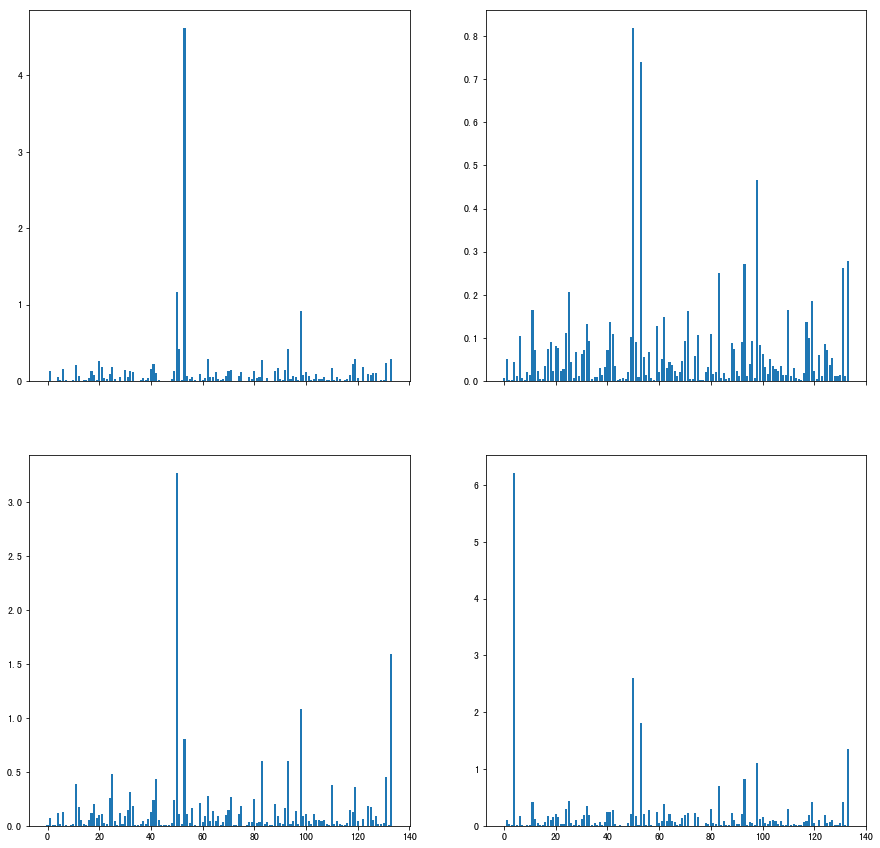

In [89]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

In [90]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              4.620428
fresh fruits                  1.163216
packaged vegetables fruits    0.922015
packaged cheese               0.423395
fresh herbs                   0.421670
soy lactosefree               0.288475
yogurt                        0.287095
frozen produce                0.282264
milk                          0.279848
canned jarred vegetables      0.261560
dtype: float64

In [91]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.818765
fresh vegetables                 0.739032
packaged vegetables fruits       0.465411
yogurt                           0.278152
packaged cheese                  0.271190
water seltzer sparkling water    0.262847
milk                             0.249641
chips pretzels                   0.205824
soy lactosefree                  0.185766
refrigerated                     0.164825
dtype: float64

In [92]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.268080
yogurt                           1.592411
packaged vegetables fruits       1.078795
fresh vegetables                 0.802455
packaged cheese                  0.603571
milk                             0.597768
chips pretzels                   0.481696
water seltzer sparkling water    0.452009
energy granola bars              0.432812
bread                            0.383705
dtype: float64

In [93]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula                6.214085
fresh fruits                     2.605634
fresh vegetables                 1.814085
yogurt                           1.343662
packaged vegetables fruits       1.101408
packaged cheese                  0.828169
milk                             0.695775
chips pretzels                   0.430986
water seltzer sparkling water    0.419718
soy lactosefree                  0.419718
dtype: float64

In [94]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,1.163216,4.620428,0.922015,0.287095,0.423395,0.279848,0.242581,0.188061
1,0.818765,0.739032,0.465411,0.278152,0.271190,0.249641,0.262847,0.205824
2,3.268080,0.802455,1.078795,1.592411,0.603571,0.597768,0.452009,0.481696
3,2.605634,1.814085,1.101408,1.343662,0.828169,0.695775,0.419718,0.430986


In [95]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,14.313617,56.855335,11.345590,3.532759,5.209970,3.443591,2.985011,2.314127
1,24.879949,22.457101,14.142517,8.452265,8.240707,7.585883,7.987172,6.254407
2,36.816033,9.039932,12.152987,17.939046,6.799437,6.734058,5.092034,5.426474
3,28.201220,19.634146,11.920732,14.542683,8.963415,7.530488,4.542683,4.664634


# 总结

该项目数据集为Instacart购物订单数据，数据集大小为300w+，涉及5张相互关联的sql表；

第一，对数据进行初步的加载，查看，了解各表之间的业务关联和各个字段的真实意义；

第二，对数据进行初步查看，熟悉数据结构，缺失值等数据基础信息；

第三，对单张表进行数据探索，分析，找出有价值的信息；

第四，多张表联合，基于多因素进行分析；

第五，用PCA尝试对客户进行细分